# Differential Privacy for ML Course - Lab #1

*Master IASD, PSL - O. Cappé, January 2024*

This first lab is intended to perform basic experiments regarding attacks.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [ ]:
# Load data from the Pima Indians dataset
# Use data from https://openml.org/search?type=data&status=active&id=37
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data from a CSV file
# Replace 'diabetes.csv' with the path to your actual file
csv_file = '/content/diabetes.csv'
pima = pd.read_csv(csv_file)

# Assuming the target column is 'Outcome' and its values are 1 for positive and 0 for negative
# Modify these names/values if your dataset differs
target_column = 'Outcome'
positive_label = 1  # Replace with the actual positive label in your CSV
negative_label = 0  # Replace with the actual negative label in your CSV

# Convert the target to numeric +/- 1
outcome = np.where(pima[target_column] == positive_label, 1, -1)

# Get the number of samples
n = outcome.size

# Print class probabilities
print('Class probabilities: {0:.2f}, {1:.2f}'.format(np.sum(outcome == -1) / n, np.sum(outcome == 1) / n))

# Extract features and standardize them
# Assuming the features are all columns except the target column
features = pima.drop(columns=[target_column]).values

# Standardize the features and add an intercept column
data = np.concatenate((np.ones((n, 1)), StandardScaler().fit_transform(features)), axis=1)

# Output the shape of the final dataset
print(f'Data shape: {data.shape}')


Class probabilities: 0.65, 0.35
Data shape: (768, 9)


# L1.1 Warm-Up: Recovery of Binary Answers from Random Projections

- Complete the code below with your idea of how to predict the labels <code>y</code> from the observed random dot products <code>z</code> (assuming that the matrix <code>W</code> is known) an observe the ROC and DET curves.
- By varying <code>p</code>, find the minimal value of <code>p</code> that give non trivial recovery performance? For what value of <code>p</code> can you recover 50% of the labels at 5% FPR?
- What changes if we now assume that some of the labels in <code>y</code> are known?

we assume that we know z and W--> what is the value of Y. However this is not obvious because if the matrix w was squared and invertible we would just need this for one solution. In our case this is not true.
p<n  the number of features is less than parameters. So it is not possible to find Y exactly.

Predict Y that is dependent on a treshold.

use ridge regression with min ||z-Wy||² + lambda||Y||² and compute the gradient. So that Y = (wTw +lambda)⁻¹wTz

When lambda tends to 0 we end up in a situation of pseudo inverse where we want to min ||Y||² st z=Wy.The solution y = W^#z

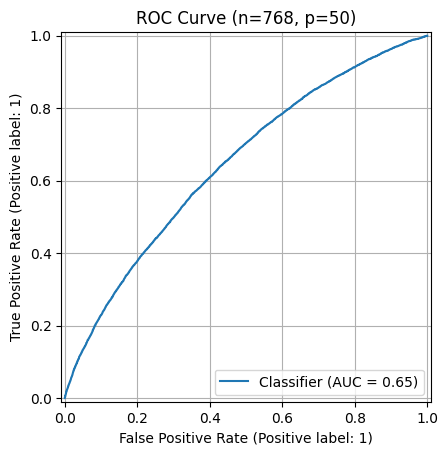

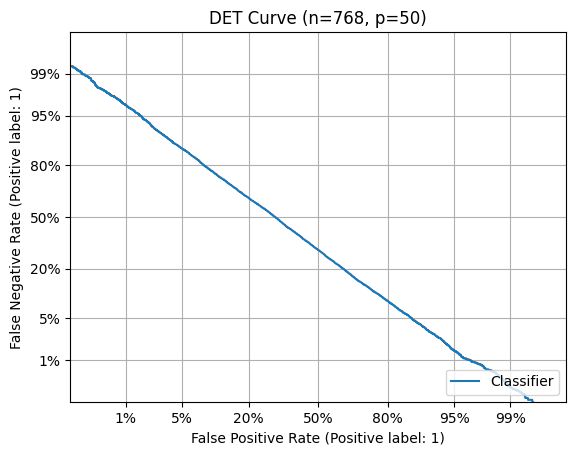

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 50
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))
for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    # Begin TODO: Use a better estimation method!
    estim[iMC, :] = np.matmul(np.linalg.pinv(W),z)
    # End TODO
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

When you also apply Ridge regression you obtain similar results.So on average for p = 50 we can recover information about 30 people. When increasing p we should be more successful.

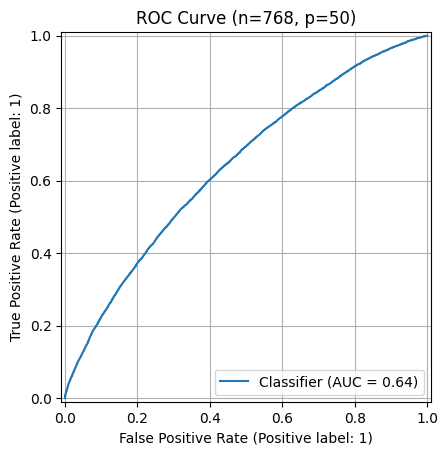

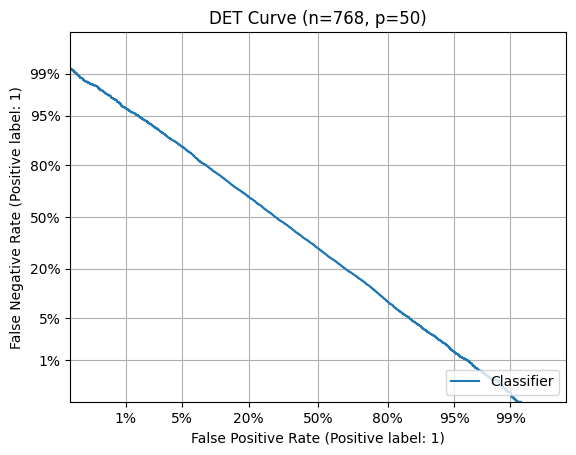

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 50
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))

lambda_reg = 0.05

for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    WTW = W.T @ W
    regularized_inverse = np.linalg.inv(WTW + lambda_reg * np.eye(n))
    W_pseudo = regularized_inverse @ W.T
    estim[iMC, :] = W_pseudo @ z  # Estimate y

# Flatten estimated values for ROC and DET plotting
flattened_estim = np.reshape(estim, nMC * n)
flattened_y = np.tile(y, nMC)
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
auc_dict = {}
# Observe p dot products with random sign vectors
for p in range(10, 300, 10):  # Start from 10 to avoid invalid matrix sizes
    nMC = 50  # Number of Monte Carlo runs
    estim = np.zeros((nMC, n))

    for iMC in range(nMC):
        # Observe dot product with random signs matrix
        W = np.power(-1, np.random.binomial(1, 0.5, size=(p, n)))
        z = np.matmul(W, y)

        # Use a better estimation method (for now, pseudoinverse)
        estim[iMC, :] = np.matmul(np.linalg.pinv(W), z)

    # Compute ROC Curve
    fpr, tpr, _ = metrics.roc_curve(np.tile(y, nMC), np.reshape(estim, nMC * n))
    auc_score = metrics.auc(fpr, tpr)

    # Store AUC score
    auc_dict[p] = auc_score


In [ ]:
print(auc_dict)

{10: 0.5652401850746269, 20: 0.5916343731343284, 30: 0.6122488597014926, 40: 0.6271341432835822, 50: 0.6453270298507463, 60: 0.6620627880597014, 70: 0.6752021432835821, 80: 0.6874238985074628, 90: 0.6971951164179104, 100: 0.7082854985074627, 110: 0.7204974388059702, 120: 0.729448023880597, 130: 0.7375463731343284, 140: 0.7476560388059701, 150: 0.7531866626865671, 160: 0.7665858029850746, 170: 0.7719924298507463, 180: 0.7821639283582089, 190: 0.7905443910447761, 200: 0.7992834507462686, 210: 0.8091636447761195, 220: 0.8130118447761194, 230: 0.8213733910447761, 240: 0.8306806417910447, 250: 0.8390182746268657, 260: 0.8446380597014925, 270: 0.8474927671641791, 280: 0.8549637791044775, 290: 0.8606450865671642}


For p =10 we already get a non trivial classifier, but the higher p is the better the AUC

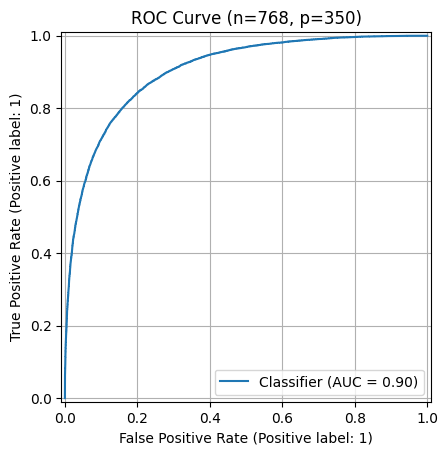

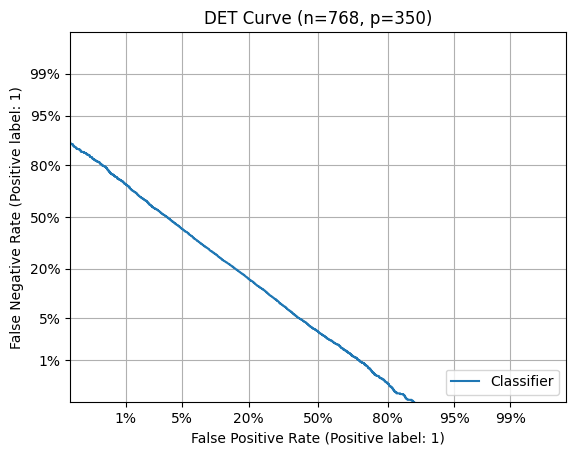

In [ ]:
# Use label mapped to {-1,1}
y = outcome
n = y.size
# Observe p dot products with random sign vectors
p = 350
# Do it several times to get statistically significant results
nMC = 50    # Number of Monte Carlo runs
estim = np.zeros((nMC, n))
for iMC in range (nMC):
    # Observe dot product with random signs matrix
    W = np.power(-1, np.random.binomial(1, 0.5, size=(p,n)))
    z = np.matmul(W, y)
    # Begin TODO: Use a better estimation method!
    estim[iMC, :] = np.matmul(np.linalg.pinv(W),z)
    # End TODO
# Plot ROC (Receiver Operating Characteristic) and DET (Detection Error Tradeoff) curves
metrics.RocCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("ROC Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()
metrics.DetCurveDisplay.from_predictions(np.tile(y, nMC), np.reshape(estim,nMC*n))
plt.title("DET Curve (n={}, p={})".format(n, p))
plt.grid(True)
plt.show()

It seems around p =350 we get can  recover 50% of the labels at 5% FPR.



Knowing the labels would allow us to get more accurate results and simplify the problem.

## Logistic Regression

In this part, we provide a utility function that can be used to compare two ROC curves on the same plot and examine the result of using logistic regression on this dataset (you can experiment with different train and test splits).

In [ ]:
def display_two_roc_curves_from_predictions(y_true1, y_score1, label1, y_true2, y_score2, label2):
    """
    Plots two ROC curves from given true labels and predicted scores.

    Parameters:
    y_true1 (array-like): True binary labels for the first set of predictions.
    y_score1 (array-like): Target scores for the first set of predictions.
    label1 (str): Label for the first ROC curve.
    y_true2 (array-like): True binary labels for the second set of predictions.
    y_score2 (array-like): Target scores for the second set of predictions.
    label2 (str): Label for the second ROC curve.
    """
    fpr1, tpr1, tresh = metrics.roc_curve(y_true1, y_score1)
    auc1 = metrics.roc_auc_score(y_true1, y_score1)
    plt.plot(fpr1, tpr1, label=label1+' (AUC={0:.2f})'.format(auc1))
    fpr2, tpr2, tresh = metrics.roc_curve(y_true2, y_score2)
    auc2 = metrics.roc_auc_score(y_true2, y_score2)
    plt.plot(fpr2, tpr2, label=label2+' (AUC={0:.2f})'.format(auc2))
    plt.legend(loc=0)
    plt.grid(True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

Training and test accuracies: 0.82, 0.78


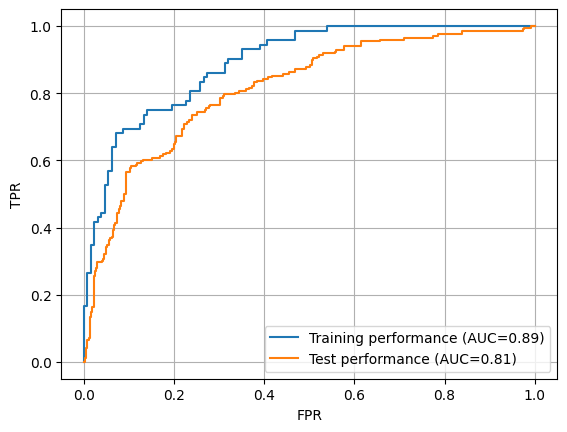

In [ ]:
# Fit logistic regression to the data (without intercept as we explicitly added it to the data already)
X = data
y = outcome
(n, d) = X.shape
n_train = 200
n_test = n - n_train
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n_train, random_state=45)
logreg = LogisticRegression(fit_intercept=False)
logreg.fit(X_train, y_train)
# Plot training and test performance as ROCs
y_train_pred = logreg.predict_proba(X_train)[:,1]
y_test_pred = logreg.predict_proba(X_test)[:,1]
print('Training and test accuracies: {0:.2f}, {1:.2f}'.format(np.sum(y_train*(y_train_pred-0.5) > 0)/n_train,
    np.sum(y_test*(y_test_pred-0.5) > 0)/n_test))
display_two_roc_curves_from_predictions(y_train, y_train_pred, 'Training performance',
    y_test, y_test_pred, 'Test performance')
plt.show()

## L1.2 Model Inversion Attack




- Write a function that computes the gradients of the logistic loss for all the training points <code>(X,y)</code>.
- Use these to construct a test statistic that can be used to guess the value of an unknown data point in <code>y</code> given <code>p</code> other ones, which are assumed to be known (<code>X</code> as well as the fitted model <code>logreg</code> are also assumed to be known).
- Experimenting with random subsets of the data (using the provided code as example), for what values of <code>p</code> does this approach start to give non trivial recovery performance?
- Try different values of the training size <code>n</code>; how does it modify the previous conclusion? What aspect of the model appears to be important for ensuring the success of the recovery?

Not use test. Go back to training and want to Y given the value of the fited model (logreg).

We have lables (X1...Xn;Y1,...Yn)
we knwow θ and all the labels except 1, so [θ, X1,...Xn; {Yj} ] how do we find the missing one.
This method can be extended similarly to the pseudo-inverse with p very close to n.

In [ ]:

def logreg_gradients(X, y, logreg):
    """
    Compute the gradients of the logistic regression loss function with respect to model parameters.

    Parameters:
    X (numpy.ndarray): Feature matrix of shape (n, d), where n is the number of samples and d is the number of features.
    y (numpy.ndarray): Target labels of shape (n,), where n is the number of samples.
    logreg (object): A trained logistic regression model.

    Returns:
    numpy.ndarray: The gradient matrix of shape (n, d), where each row corresponds to the gradient for a single sample.
    """
    n, d = X.shape
    p_hat = logreg.predict_proba(X)[:, 1]  # Predicted probabilities
    gradients = np.zeros((n, d))  # Initialize gradient matrix

    for i in range(n):
        gradients[i, :] = X[i, :] * (p_hat[i] - y[i])  # Compute gradient for each sample

    return gradients


Assume known labels are equal to p. Find p+1 randomindex from the training set and recostruct the first one with the other. Very bad when p is very small compared to n. (p=195). The model does something that is not trivial. (look at prediction of Xi)

Compute gradient of logistic regression, and what does sklearn do when training the logisitic regression

min average training loss and invert this condition

Y compatible with condition on gradient. 1 obs missing

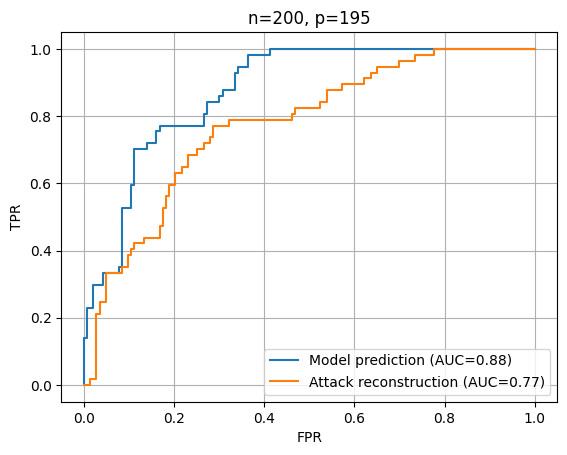

In [ ]:
# We will work on recovering data from the training sample
X = X_train
y = y_train
(n, d) = X.shape
# Compute the probabilistic predictions from the model
p_hat = logreg.predict_proba(X)[:,1]
# Try reconstruction attack assuming p known labels on randomly chosen data subsets
p =195  # Number of known labels
# Number of Monte Carlo experiments
nMC = 200
y_true = np.zeros(nMC)
y_guess = np.zeros(nMC)
y_pred = np.zeros(nMC)

grads = logreg_gradients(X_train, y_train, logreg)

for i in range(nMC):
        ind = np.random.permutation(len(X_train))
        y_true[i] = y_train[ind[0]]
        y_pred[i] = p_hat[ind[0]]

        known_grad = np.sum(grads[ind[1:p+1]], axis=0)

        g1 = X_train[ind[0]] * (p_hat[ind[0]] - 1)
        g0 = X_train[ind[0]] * p_hat[ind[0]]

        s1 = known_grad + g1
        s0 = known_grad + g0

        y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

    # End TODO
display_two_roc_curves_from_predictions(y_true, y_pred, 'Model prediction',
    y_true, y_guess, 'Attack reconstruction')
plt.title("n={}, p={}".format(n, p))
plt.show()

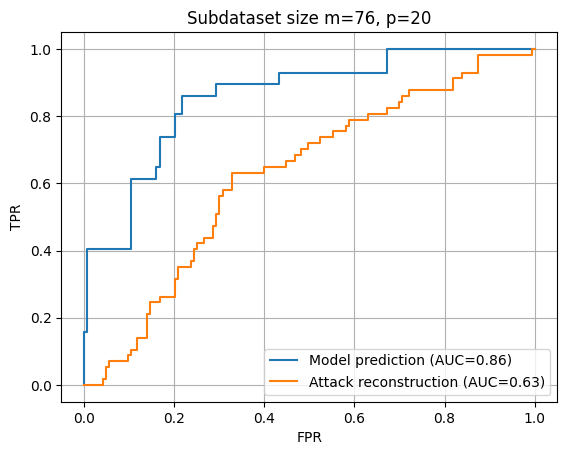

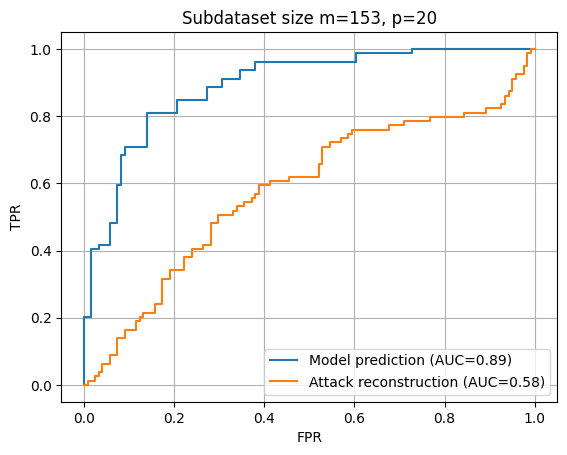

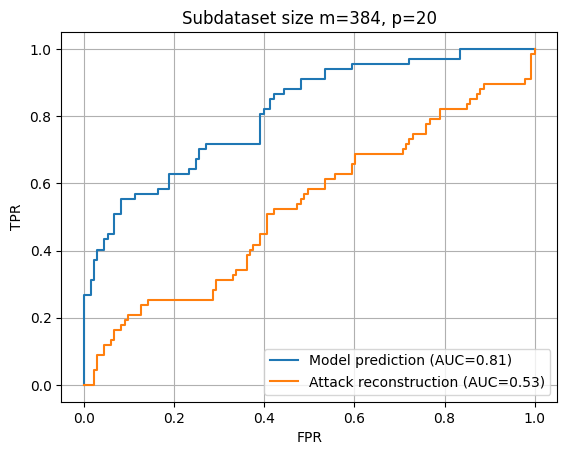

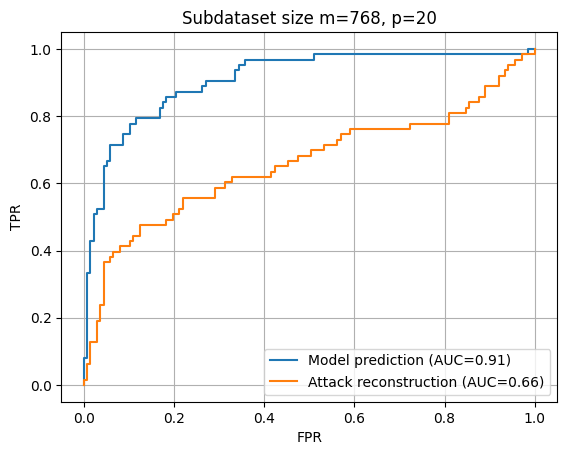

In [ ]:

def experiment_with_subdatasets(subdataset_sizes):
    p = 20

    for m in subdataset_sizes:

        # Randomly select a subset of size m from the full dataset
        indices = np.random.choice(len(data), m, replace=False)
        X_subset = data[indices]
        y_subset = outcome[indices]

        # Train a logistic regression model on the subset
        logreg = LogisticRegression()
        logreg.fit(X_subset, y_subset)

        # Compute predicted probabilities on the subset
        p_hat = logreg.predict_proba(X_subset)[:, 1]

        # Calculate gradients for each sample in the subset
        grads = logreg_gradients(X_subset, y_subset, logreg)

        # Run the attack for this subdataset size
        y_true = np.zeros(nMC)
        y_pred = np.zeros(nMC)
        y_guess = np.zeros(nMC)

        for i in range(nMC):
            ind = np.random.permutation(len(X_subset))
            y_true[i] = y_subset[ind[0]]
            y_pred[i] = p_hat[ind[0]]

            # Known gradient information
            known_grad = np.sum(grads[ind[1:p+1]], axis=0)

            g1 = X_subset[ind[0]] * (p_hat[ind[0]] - 1)
            g0 = X_subset[ind[0]] * p_hat[ind[0]]

            s1 = known_grad + g1
            s0 = known_grad + g0

            y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

        # Plot ROC curves for each subdataset size
        display_two_roc_curves_from_predictions(
            y_true, y_pred, 'Model prediction', y_true, y_guess, 'Attack reconstruction'
        )
        plt.title(f"Subdataset size m={m}, p={p}")
        plt.show()

# Define a range of subdataset sizes to test (e.g., 10%, 20%, 50%, 100% of the dataset)
subdataset_sizes = [int(0.1 * len(data)), int(0.2 * len(data)), int(0.5 * len(data)), len(data)]
experiment_with_subdatasets(subdataset_sizes)


With subsets of data we can see that the results vary. With p = 20 we get better than average results but if increase its value we get better AUC for the attack reconstruction.

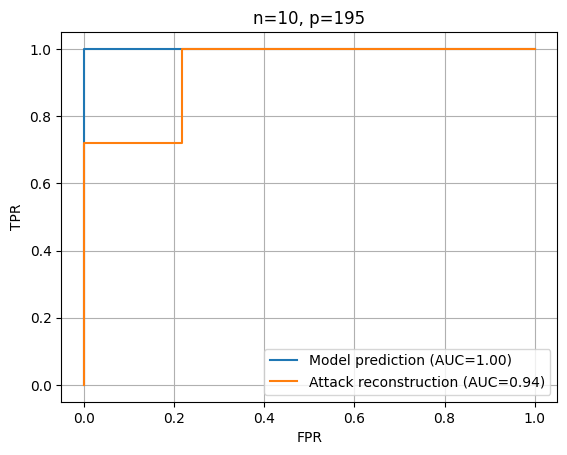

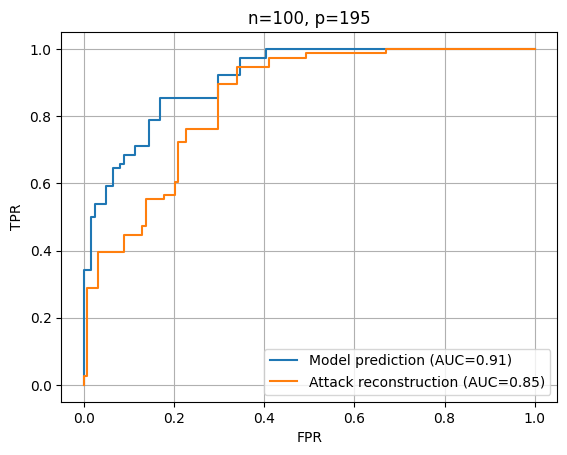

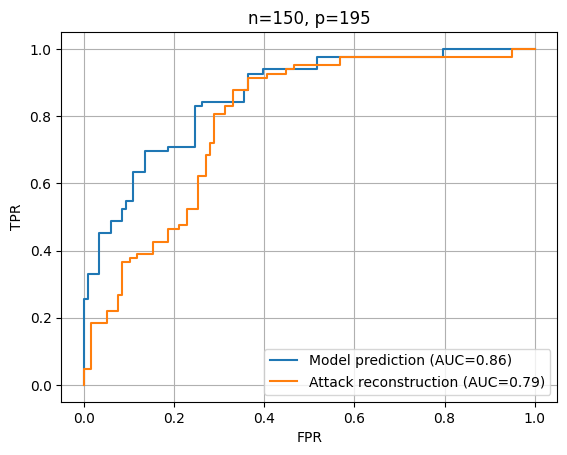

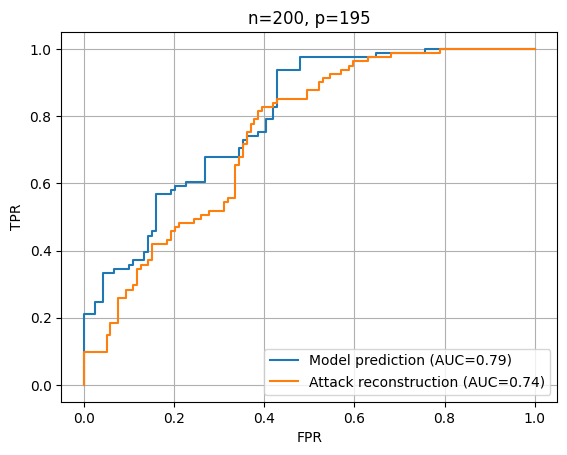

In [ ]:

def experiment_with_training_size(n_values):
    for n in n_values:
        # Split the data into training and testing sets with a fixed test size
        X_train, X_test, y_train, y_test = train_test_split(data, outcome, train_size=n, random_state=42)

        # Train a logistic regression model
        logreg = LogisticRegression()
        logreg.fit(X_train, y_train)

        # Compute predicted probabilities on the training data
        p_hat = logreg.predict_proba(X_train)[:, 1]

        # Calculate gradients for each sample
        grads = logreg_gradients(X_train, y_train, logreg)

        # Run the attack for this training size
        y_true = np.zeros(nMC)
        y_pred = np.zeros(nMC)
        y_guess = np.zeros(nMC)

        for i in range(nMC):
            ind = np.random.permutation(len(X_train))
            y_true[i] = y_train[ind[0]]
            y_pred[i] = p_hat[ind[0]]

            known_grad = np.sum(grads[ind[1:p+1]], axis=0)

            g1 = X_train[ind[0]] * (p_hat[ind[0]] - 1)
            g0 = X_train[ind[0]] * p_hat[ind[0]]

            s1 = known_grad + g1
            s0 = known_grad + g0

            y_guess[i] = 0.5 * ((np.sum(np.square(s1))) - np.sum(np.square(s0)))

        # Plot ROC curves for each training size
        display_two_roc_curves_from_predictions(
            y_true, y_pred, 'Model prediction', y_true, y_guess, 'Attack reconstruction'
        )
        plt.title(f"n={n}, p={p}")
        plt.show()

# Define a range of training sizes to test
n_values = [10, 100, 150, 200]
experiment_with_training_size(n_values)


We can see that the higher n is the less sucessful the attack is and with very few points it has a very high AUC.